### Nome: André De Marco Toyama

# SUDOKU SOLVER

An opencv and python project, that reads an image with a sudoku board, an returns the solution of that board. Along with the project there is 2 different sudoku boards pictures to test

In [52]:
INPUT = 'board1.jpg'

##**Install packages:**

In [2]:
! pip install pytesseract
! sudo apt install tesseract-ocr
! pip install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.6-py2.py3-none-any.whl size=13629 sha256=f091eb238a5c18402121240c6befacade8af0035cfbd6920631642cf81135a6b
  Stored in directory: /root/.cache/pip/wheels/ee/71/72/b98430261d849ae631e283dfc7ccb456a3fb2ed2205714b63f
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

## **Imports:**

In [44]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
import operator
import pytesseract

##**Load image:**

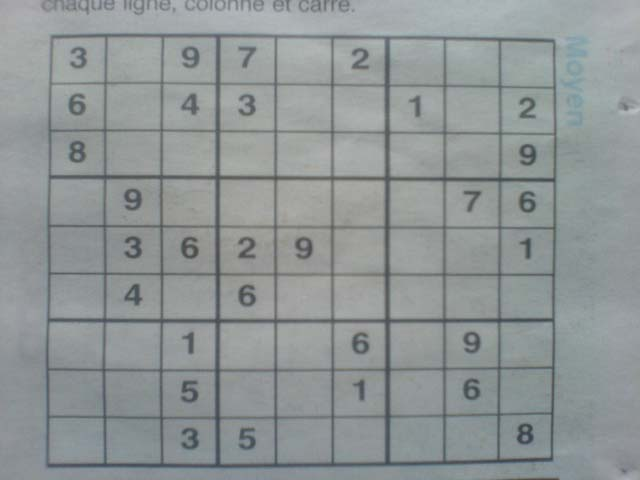

In [62]:
board_original = cv.imread(INPUT)
cv2_imshow(board_original)

##**Pre-Processing:**
Treating the image for better recognition

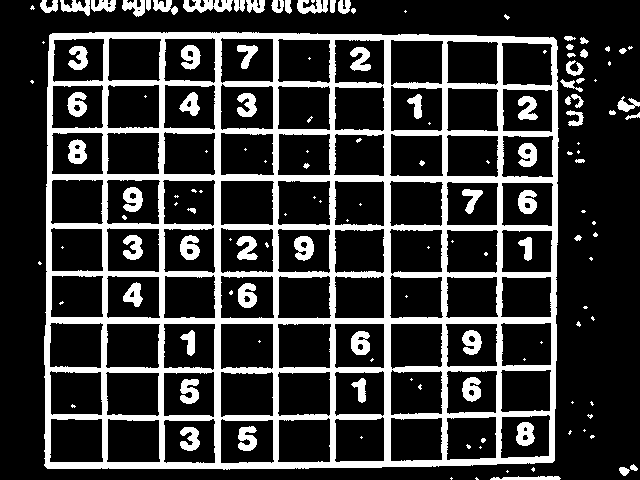

In [64]:
# change from BGR to gray
board = cv.cvtColor(board_original.copy(), cv.COLOR_BGR2GRAY)

# gaussian blur
board = cv.GaussianBlur(board, (9, 9), 0)

# thresholding
board = cv.adaptiveThreshold(board, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11,2)

# invert bits
board = cv.bitwise_not(board, board)

# dilatation kernel
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)

# dilate 
board = cv.dilate(board, kernel)

cv2_imshow(board)

##**Cropping:**
Find the biggest contour, that must be the board, and isolate it

In [55]:
def distance_between(p1, p2): 
    a = p2[0] - p1[0] 
    b = p2[1] - p1[1] 
    return np.sqrt((a ** 2) + (b ** 2))

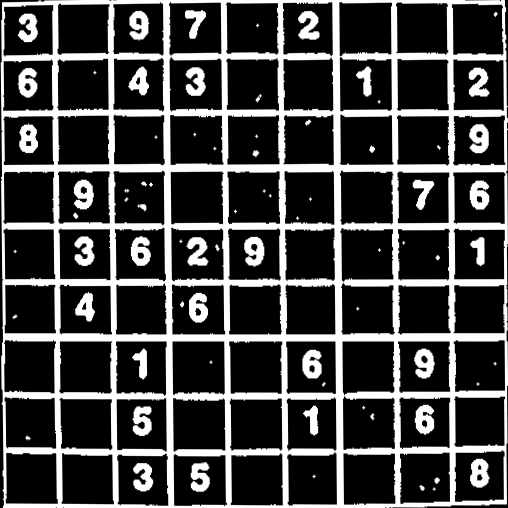

In [65]:
# find contours
contours, h = cv.findContours(board, cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

# get the contour with the biggest area
maxarea = 0
cnt = None
image = cv.drawContours(board, contours, -1, (0,255,0), 3)
for c in contours:
  if cv.contourArea(c) > maxarea:
    cnt = c
    maxarea = cv.contourArea(c)

# get the 4 corners of the board
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in
                      cnt]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in
                  cnt]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in
                     cnt]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in
                   cnt]), key=operator.itemgetter(1))

corners = [cnt[top_left][0], cnt[top_right][0], cnt[bottom_right][0], cnt[bottom_left][0]]
top_left, top_right, bottom_right, bottom_left = corners[0], corners[1], corners[2], corners[3]
src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32') 

# get the distance between the corners
side = max([  distance_between(bottom_right, top_right), 
            distance_between(top_left, bottom_left),
            distance_between(bottom_right, bottom_left),   
            distance_between(top_left, top_right) ])

dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

m = cv.getPerspectiveTransform(src, dst)

# crop
board = cv.warpPerspective(board, m, (int(side), int(side)))

cv2_imshow(board)

##**Get digit cell:**
Isolate the image of the 81 differents cell in the board

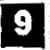

In [66]:
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

board = cv.resize(board, (450, 450))
boxes = splitBoxes(board)

cv2_imshow(boxes[2])

##**Digit Recognition:**
Treat the cell image and use the pytesseract library to recognize the digit

In [67]:
# pytesseract path
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

# config to image_to_string func
custom_config = r'--oem 3 --psm 6'

# treat, the cell, recognize the digit and build the board array
board_array = []
for i in range(len(boxes)):
  test = boxes[i]
  test = cv.erode(test, kernel)
  test = cv.bitwise_not(test, test)
  test = test[6:44, 6:44]

  # Using Tesseract OCR
  digit = pytesseract.image_to_string(test, config=custom_config)
  if digit == '\x0c':
    board_array.append('0')
  else:
    board_array.append(digit)

# treat the board
board_array = [n.replace("\n\x0c", "") for n in board_array]
board_array = [n.replace("\x0c", "") for n in board_array]

board_array = [
                [
                  int(board_array[i]),
                  int(board_array[i+1]),
                  int(board_array[i+2]),
                  int(board_array[i+3]),
                  int(board_array[i+4]),
                  int(board_array[i+5]),
                  int(board_array[i+6]),
                  int(board_array[i+7]),
                  int(board_array[i+8])
                ] for i in range(0, len(board_array), 9)
              ]

print('DIGITAL BOARD:')
for line in board_array:
  print(line)

DIGITAL BOARD:
[3, 0, 9, 7, 0, 2, 0, 0, 0]
[6, 0, 4, 3, 0, 0, 1, 0, 2]
[8, 0, 0, 0, 0, 0, 0, 0, 9]
[0, 9, 0, 0, 0, 0, 0, 7, 6]
[0, 3, 6, 2, 9, 0, 0, 0, 1]
[0, 4, 0, 6, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 6, 0, 9, 0]
[0, 0, 5, 0, 0, 1, 0, 6, 0]
[0, 0, 3, 5, 0, 0, 0, 0, 8]


##**Sudoku Solver:**

In [68]:
# check if number is valid in cell
def isValid(board, row, col, num):
 
    #check row
    for i in range(9):
        if board[row][i] == num:
            return False
 
    #check col
    for i in range(9):
        if board[i][col] == num:
            return False
 
    #get top-left corner
    c_row = row - row%3
    c_col = col - col%3
 
    #check 3x3 square
    for i in range(c_row, c_row+3):
        for j in range(c_col, c_col+3):
            if board[i][j] == num:
                return False
 
    #return True if none of the cases above returns False
    return True
 
 # recursively solve the board and input the answer for each cell
def solveBoard(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                for num in range(1,10):
                    if isValid(board, i, j, num):
                        board[i][j] = num
                        result = solveBoard(board)
                        if result == True:
                            return True
                        else:
                            board[i][j] = 0
                return False
    return True

solveBoard(board_array)

print('SOLUTION:')
for line in board_array:
  print(line)

SOLUTION:
[3, 5, 9, 7, 1, 2, 6, 8, 4]
[6, 7, 4, 3, 8, 9, 1, 5, 2]
[8, 1, 2, 4, 6, 5, 7, 3, 9]
[2, 9, 8, 1, 4, 3, 5, 7, 6]
[5, 3, 6, 2, 9, 7, 8, 4, 1]
[1, 4, 7, 6, 5, 8, 9, 2, 3]
[7, 2, 1, 8, 3, 6, 4, 9, 5]
[4, 8, 5, 9, 2, 1, 3, 6, 7]
[9, 6, 3, 5, 7, 4, 2, 1, 8]
